In [3]:
%cd ..

/home/jhkim/workspace/lrquant


/home/jhkim/workspace/lrquant/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import gc
from mpl_toolkits.mplot3d import Axes3D
import os
import psutil
process = psutil.Process()

import matplotlib.style as mplstyle
mplstyle.use('fast')

In [ ]:
# from scripts.utils import load_layer_input
# layer_inps = load_layer_input(cache_dir=f"../cache/wikitext2_128_2/llama-2-7b-hf", batch_index=32)

from models.LMClass import LMClass

lm = LMClass("./huggingface/llama-2-7b-hf")


from datautils import get_loaders

dataloader, _ = get_loaders(
    name="wikitext2",
    nsamples=128,
    seed=2,
    model=lm.model_name,
    seqlen=lm.seqlen,
    cache_dir=f"./cache/wikitext2_128_2/dataloader.cache",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

vocab size:  32000
Loading train from ./cache/wikitext2_128_2/dataloader.cache


In [ ]:
layer_inps = torch.zeros((32, 2048, 4096), dtype=torch.float32)

for i, layer in enumerate(lm.model.model.layers):

    def layer_hook(layer_index):
        def _fn(module, input: tuple[torch.Tensor], output):
            layer_inps[layer_index] = input[0][0].detach().clone()

        return _fn

    layer._forward_hooks.clear()
    layer.register_forward_hook(layer_hook(i))

batch_index = 32
with torch.no_grad():
    lm.model.eval()
    lm.model.to(lm.device)
    lm.model(dataloader[batch_index][0].to(lm.device))
    lm.model.cpu()
    gc.collect()
    torch.cuda.empty_cache()

In [55]:
magnitudes = layer_inps.square().mean(dim=2) # [33, 2048]
# magnitudes = magnitudes.clip(0, 10)

pd.DataFrame(layer_inps.square().mean(dim=2).max(dim=1)).T

,0,1
0,tensor(0.0004),tensor(1701)
1,tensor(0.0032),tensor(4)
2,tensor(2430.2410),tensor(227)
3,tensor(2437.4927),tensor(227)
4,tensor(2437.1868),tensor(227)
5,tensor(2454.0649),tensor(227)
6,tensor(2453.8433),tensor(227)
7,tensor(2453.6953),tensor(227)
8,tensor(2453.6431),tensor(227)
9,tensor(2453.4946),tensor(227)


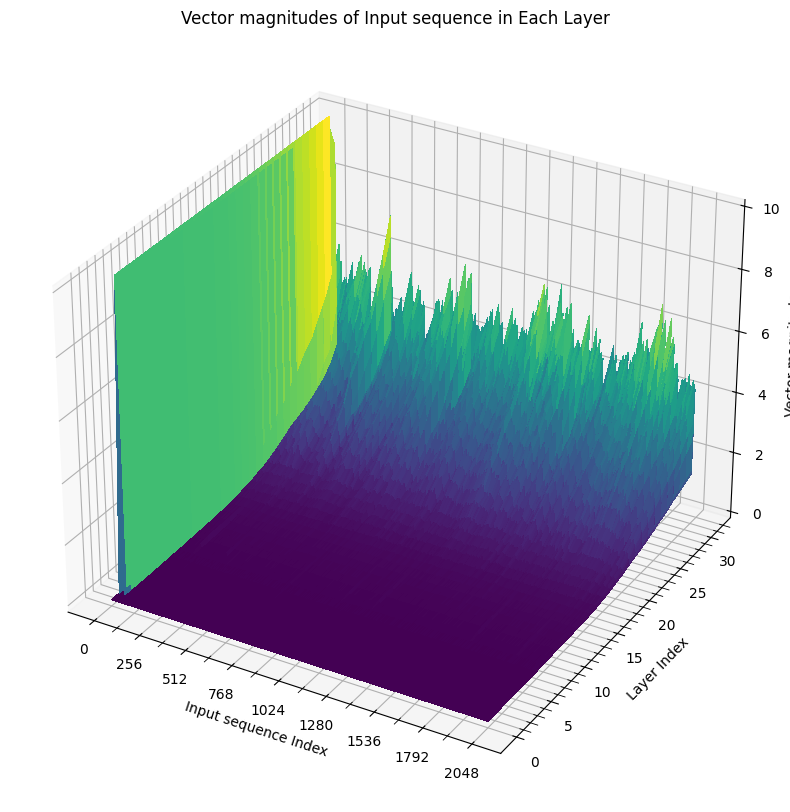

In [29]:
# plot magnitudes 3d chart
# x axis is layer index, y axis is neuron index, z axis is magnitude

fig = plt.figure(figsize=(20, 10))
ax: Axes3D = fig.add_subplot(111, projection='3d')
x = np.arange(magnitudes.shape[0])
y = np.arange(magnitudes.shape[1])
X, Y = np.meshgrid(x, y)
Z = magnitudes.T.numpy()

ax.plot_surface(Y, X, Z, cmap='viridis', linewidth=0, antialiased=False, cstride=1, rstride=1)
ax.set_ylabel('Layer Index')
ax.set_xlabel('Input sequence Index')
ax.set_zlabel('Vector magnitude')
ax.set_title('Vector magnitudes of Input sequence in Each Layer')

# x ticks
ax.set_yticks(range(0, 33, 5))
ax.set_yticks(range(0, 33, 1), minor=True)
ax.set_xticks(range(0, 2048+1, 256))
ax.set_xticks(range(0, 2048+1, 128), minor=True)

plt.show()

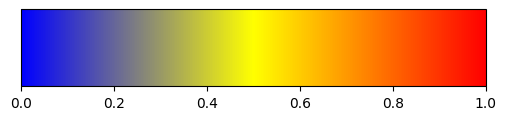

In [46]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

colors = [(0, "blue"), (0.5, "yellow"), (1, "red")]  # (position, color)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(figsize=(6, 1))
norm = Normalize(vmin=0, vmax=1)
cb = ColorbarBase(ax, cmap=custom_cmap, norm=norm, orientation="horizontal")
plt.show()


def plot_single_layer_inps(single_layer_inps: torch.Tensor):
    data = single_layer_inps.abs()
    fig = plt.figure(figsize=(20, 10))
    ax: Axes3D = fig.add_subplot(projection="3d")
    x = np.arange(data.shape[0])
    y = np.arange(data.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = data.T
    # Z = Z ** (1 / 3)
    

    ax.plot_surface(
        X,
        Y,
        Z,
        cmap=custom_cmap,
        rstride=16,
        cstride=1,
        linewidth=1,
        antialiased=False,
        alpha=0.8,
    )

    ax.set_xlabel("Input sequence(token) Index")
    ax.set_ylabel("Hidden state(channel) Index")
    ax.set_zlabel("Magnitude")

    ax.set_xticks(np.arange(0, x.shape[0] + 1, x.shape[0] / 8))
    ax.set_xticks(np.arange(0, x.shape[0] + 1, x.shape[0] / 16), minor=True)
    ax.set_yticks(np.arange(0, y.shape[0] + 1, y.shape[0] / 8))
    ax.set_yticks(np.arange(0, y.shape[0] + 1, y.shape[0] / 16), minor=True)
    zticks = np.arange(0, Z.max() + 1, Z.max() / 8)
    ax.set_zticks(zticks)
    # ax.set_zticklabels(zticks ** 3, fontsize=8)

    ax.set_zlim(Z.min(), Z.max())

    return fig, ax

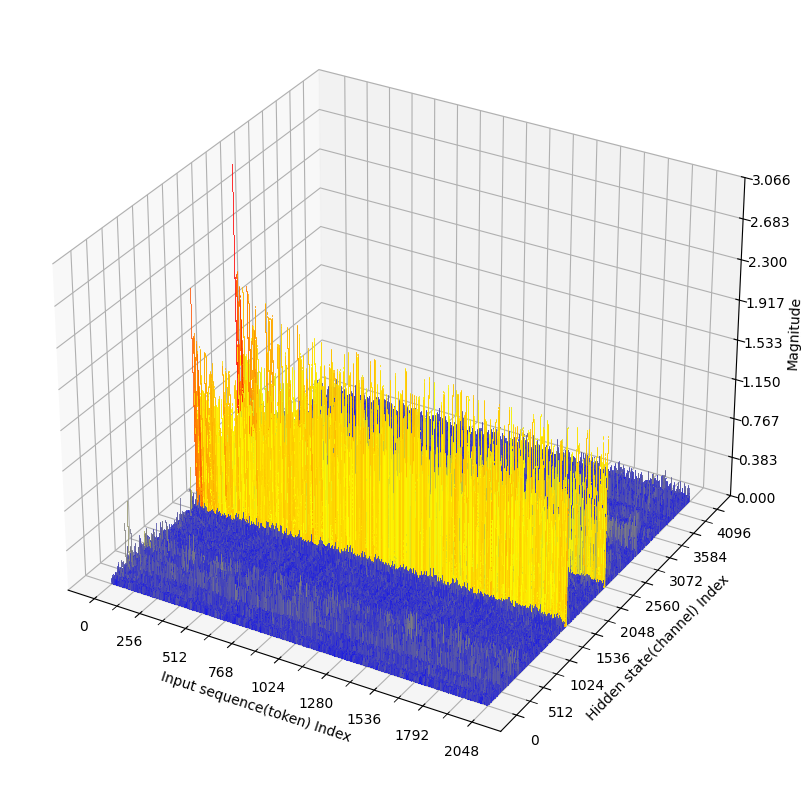

In [47]:
fig, ax = plot_single_layer_inps(layer_inps[1])
fig.show()

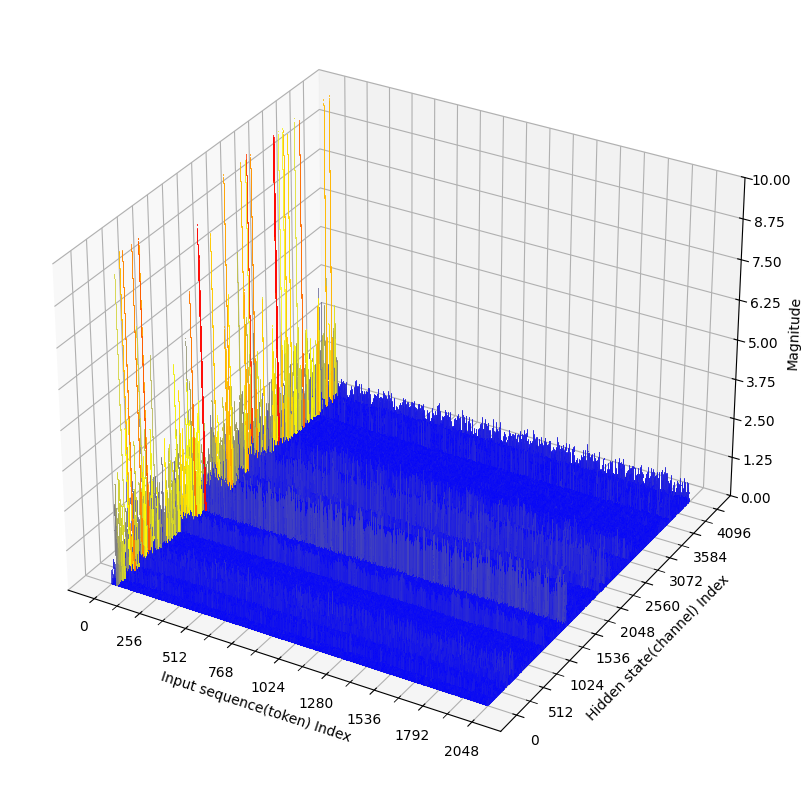

In [48]:
fig, ax = plot_single_layer_inps(layer_inps[3].clip(0, 10))
fig.show()

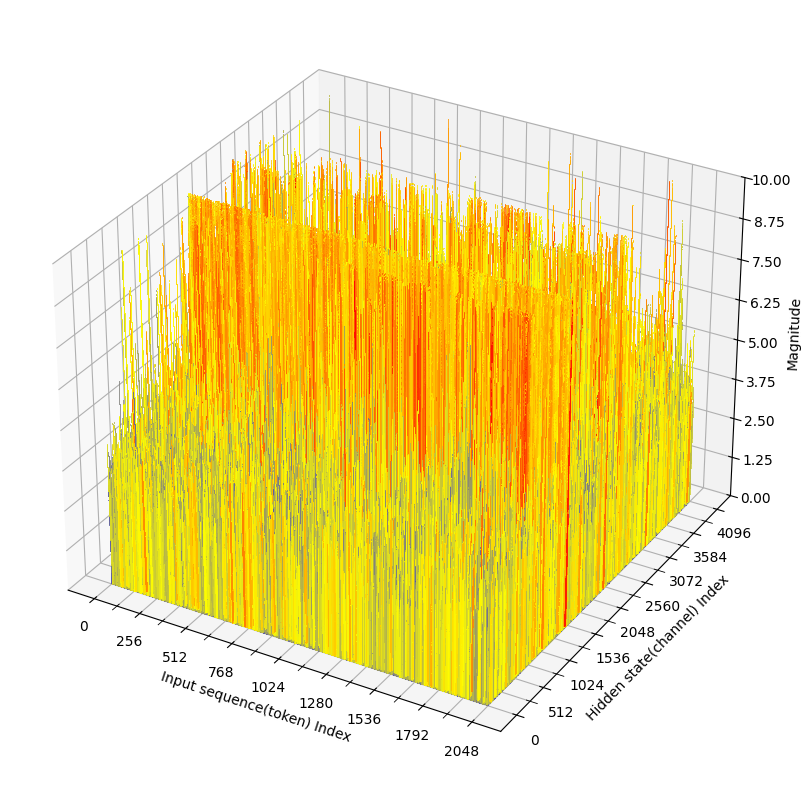

In [49]:
fig, ax = plot_single_layer_inps(layer_inps[28].clip(0, 10))
fig.show()

In [33]:
for layer_index in range(33):
    fig, ax = plot_single_layer_inps(layer_inps[layer_index])
    fig.savefig(f'./fig/batch{batch_index}_non_uniform/surface_layer{layer_index}.png', bbox_inches='tight')
    print(f"Layer {layer_index} saved")
    # fig.show()
    plt.close(fig)

Layer 0 saved
Layer 1 saved
Layer 2 saved
Layer 3 saved
Layer 4 saved
Layer 5 saved
Layer 6 saved
Layer 7 saved
Layer 8 saved
Layer 9 saved
Layer 10 saved
Layer 11 saved
Layer 12 saved
Layer 13 saved
Layer 14 saved
Layer 15 saved
Layer 16 saved
Layer 17 saved
Layer 18 saved
Layer 19 saved
Layer 20 saved
Layer 21 saved
Layer 22 saved
Layer 23 saved
Layer 24 saved
Layer 25 saved
Layer 26 saved
Layer 27 saved
Layer 28 saved
Layer 29 saved
Layer 30 saved
Layer 31 saved
Layer 32 saved


In [ ]:
import time


def plot_single_layer_inps_fill_between(single_layer_inps: torch.Tensor):
    data = single_layer_inps.abs()
    fig = plt.figure(figsize=(20, 10))
    ax: Axes3D = fig.add_subplot(projection="3d")

    X = np.arange(data.shape[1])
    Y = np.arange(data.shape[0])
    facecolors = plt.colormaps["rainbow"](np.linspace(0, 1, len(Y)))

    for y in Y:
        start_time = time.time()
        Z = data[y]

        ax.fill_between(X, y, Z, X, y+1, 0)
        # ax.scatter(X, y, Z, s=1, c=Z, alpha=0.5, cmap='rainbow')
        # ax.bar(X, Z, zs=y, zdir='y')
        
        # # standardize the data
        mean = Z.mean()
        std = Z.std()
        print(f"Layer {y} mean: {mean}, std: {std} time taken: {time.time() - start_time:.2f} seconds")

    # _x = np.arange(abs_single_layer_inps.shape[1])
    # _y = np.arange(abs_single_layer_inps.shape[0])
    # _xx, _yy = np.meshgrid(_x, _y)
    # x, y = _xx.ravel(), _yy.ravel()

    # top = abs_single_layer_inps.ravel()
    # bottom = np.zeros_like(top)
    # width = depth = 1
    # ax.bar3d(x, y, bottom, width, depth, top, shade=True, color='blue', alpha=0.5)

    ax.set_xlabel("Hidden state Index")
    ax.set_ylabel("Input sequence Index")
    ax.set_zlabel("Magnitude")

    # log scale
    # ax.set_zscale('log')
    ax.set_xticks(np.arange(0, X.shape[0] + 1, X.shape[0] / 8))
    ax.set_xticks(np.arange(0, X.shape[0] + 1, X.shape[0] / 16), minor=True)
    ax.set_yticks(np.arange(0, Y.shape[0] + 1, Y.shape[0] / 8))
    ax.set_yticks(np.arange(0, Y.shape[0] + 1, Y.shape[0] / 16), minor=True)

    return fig, ax

In [ ]:
layer_index = 0

fig, ax = plot_single_layer_inps_fill_between(layer_inps[layer_index])
print("fig finished")
fig.savefig(f'./fig/scatter_layer_{layer_index}.png')
print("fig saved")
fig.show()

Layer 0 mean: 0.0055389404296875, std: 0.0063629150390625 time taken: 3.06 seconds
Layer 1 mean: 0.0135040283203125, std: 0.01000213623046875 time taken: 2.26 seconds
Layer 2 mean: 0.0138702392578125, std: 0.010345458984375 time taken: 2.37 seconds
Layer 3 mean: 0.0124053955078125, std: 0.0094146728515625 time taken: 1.75 seconds
Layer 4 mean: 0.010406494140625, std: 0.008270263671875 time taken: 2.52 seconds
Layer 5 mean: 0.01427459716796875, std: 0.0108795166015625 time taken: 1.78 seconds
Layer 6 mean: 0.0129241943359375, std: 0.0099639892578125 time taken: 2.70 seconds
Layer 7 mean: 0.00994873046875, std: 0.007717132568359375 time taken: 1.81 seconds
Layer 8 mean: 0.00982666015625, std: 0.00788116455078125 time taken: 2.94 seconds
Layer 9 mean: 0.00608062744140625, std: 0.006435394287109375 time taken: 1.79 seconds
Layer 10 mean: 0.0149993896484375, std: 0.011322021484375 time taken: 1.79 seconds
Layer 11 mean: 0.013427734375, std: 0.010040283203125 time taken: 3.16 seconds
Layer 1

KeyboardInterrupt: 

In [ ]:
X = np.arange(magnitudes.shape[1])
Y = np.arange(magnitudes.shape[0])

fig = plt.figure()
ax: Axes3D = fig.add_subplot(projection="3d")
facecolors = plt.colormaps["viridis_r"](np.linspace(0, 1, len(Y)))

for y in Y:
    # Note fill_between can take coordinates as length N vectors, or scalars
    Z = magnitudes[y].numpy()
    ax.fill_between(X, y, Z, X, y, 0, facecolors=facecolors[i], alpha=0.7)
    print(f"Layer {y} done. {process.memory_info().rss / 1024 ** 2:.2f} MB")  # in bytes

ax.set(
    ylim=(0, 33),
    xlabel="Input sequence Index",
    ylabel="Layer Index",
    zlabel="Magnitude",
)

plt.show()